# Kaggle Stroke dataset

https://www.kaggle.com/fedesoriano/stroke-prediction-dataset?select=healthcare-dataset-stroke-data.csv

Showcasing imputation of missing values, clustering on categorical variables, SMOTE oversampling, logistic regression and a random-forest classification, explanation of most important variables, and an interface to add new patient details

Import libraries

In [1]:
# standard
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
import graphviz

# missing data
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

# oversampling
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# progress indicators
import pyprind
from tqdm.notebook import trange

# clustering
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# classification

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Read in the dataset

In [2]:
dirpath = r'C:\Users\joeba\OneDrive\Documents\ML\stroke'

#df = pd.read_csv(dirpath+'/healthcare-dataset-stroke-data-clean.csv')
df = pd.read_csv(dirpath+'/healthcare-dataset-stroke-data.csv')
df = df.drop('id', axis=1)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
# medical data sets are often highly imbalanced
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

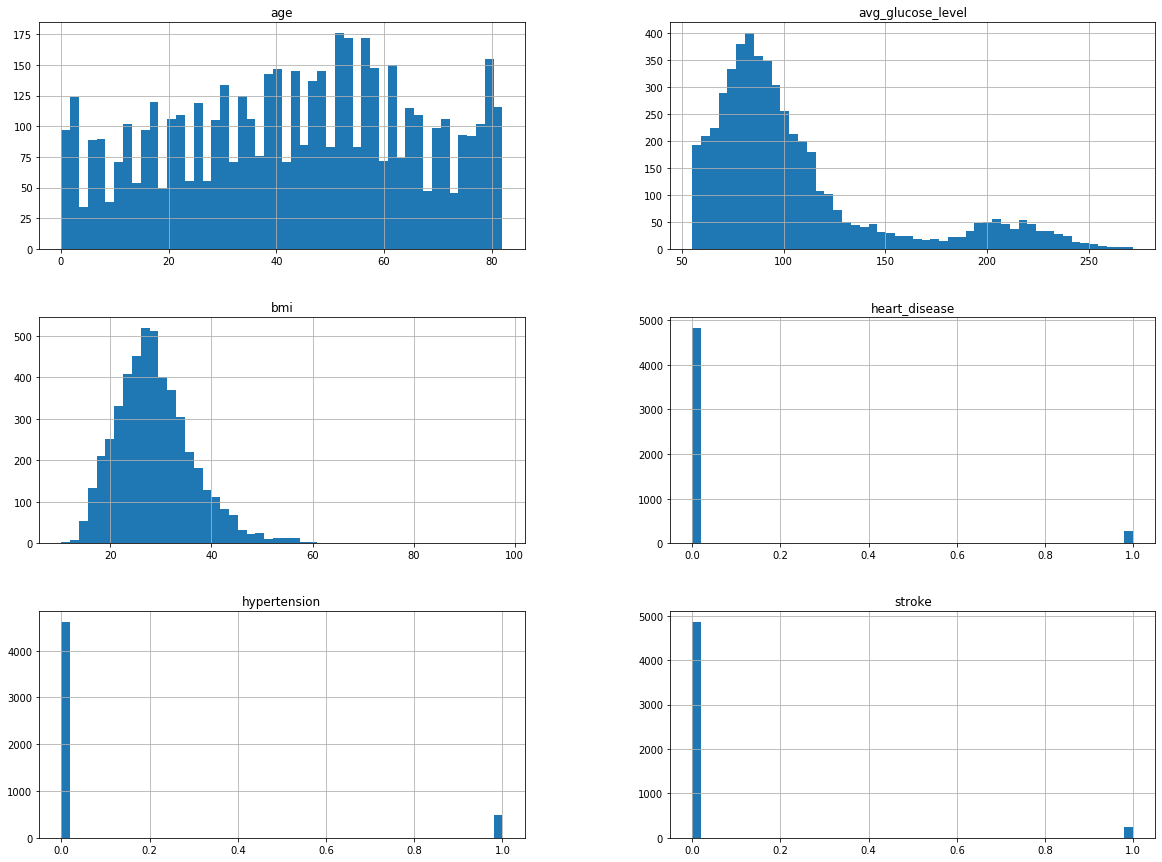

In [4]:
# show the distributions of numeric variables
df.hist(bins=50, figsize=(20,15))
plt.show()

In [5]:
# look at the categorical variables - stroke is predominantly female in real life
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [6]:
df[df['gender'] == 'Other']

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [7]:
df = df.drop(3116, axis=0)

In [8]:
df['gender'].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [9]:
df['work_type'].value_counts()

Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [10]:
# and essentially 1/3 of the data we don't know if smoked
df['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

In [11]:
smoke_known = df[df['smoking_status'] != 'Unknown']
smoke_known['stroke'].value_counts()

0    3363
1     202
Name: stroke, dtype: int64

In [12]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [13]:
df = pd.get_dummies(df, columns=['gender'], prefix='', drop_first=True)
df = pd.get_dummies(df, columns=['ever_married'], prefix='', drop_first=True)
df = pd.get_dummies(df, columns=['work_type'], prefix='work', drop_first=True)
df = pd.get_dummies(df, columns=['Residence_type'], prefix='residence', drop_first=True)
df = pd.get_dummies(df, columns=['smoking_status'], prefix='', drop_first=True)
     
# reset and reorder the columns
df.columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke', 'gender',
              'married', 'work_never_worked', 'work_private', 'work_self-employed', 'work_children',
              'residence', 'formerly smoked', 'never smoked', 'smokes']

df = df[['stroke', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender', 'married',
         'work_never_worked', 'work_private', 'work_self-employed', 'work_children', 'residence',
         'formerly smoked', 'never smoked', 'smokes']]

df.head()

,stroke,age,hypertension,heart_disease,avg_glucose_level,bmi,gender,married,work_never_worked,work_private,work_self-employed,work_children,residence,formerly smoked,never smoked,smokes
0,1,67.0,0,1,228.69,36.6,1,1,0,1,0,0,1,1,0,0
1,1,61.0,0,0,202.21,NaN,0,1,0,0,1,0,0,0,1,0
2,1,80.0,0,1,105.92,32.5,1,1,0,1,0,0,0,0,1,0
3,1,49.0,0,0,171.23,34.4,0,1,0,1,0,0,1,0,0,1
4,1,79.0,1,0,174.12,24.0,0,1,0,0,1,0,0,0,1,0


In [14]:
# correlations
print('age                ',df['stroke'].corr(df['age']))
print('heart_disease      ',df['stroke'].corr(df['heart_disease']))
print('avg_glucose_level  ',df['stroke'].corr(df['avg_glucose_level']))
print('hypertenion        ',df['stroke'].corr(df['hypertension']))
print('married            ',df['stroke'].corr(df['married']))
print('bmi                ',df['stroke'].corr(df['bmi']))
print('residence          ',df['stroke'].corr(df['residence']))
print('gender             ',df['stroke'].corr(df['gender']))

highly_correlated = df[['stroke', 'age', 'heart_disease', 'avg_glucose_level', 'hypertension', 'married']]

age                 0.245238756231982
heart_disease       0.13490484180042825
avg_glucose_level   0.13199119156645786
hypertenion         0.12789125912919336
married             0.10829931566075356
bmi                 0.04234127718027809
residence           0.015414584210315808
gender              0.00908060016007932


Impute missing BMI values 

In [15]:
# missing values?
df.isna().sum()

stroke                  0
age                     0
hypertension            0
heart_disease           0
avg_glucose_level       0
bmi                   201
gender                  0
married                 0
work_never_worked       0
work_private            0
work_self-employed      0
work_children           0
residence               0
formerly smoked         0
never smoked            0
smokes                  0
dtype: int64

In [16]:
# closer look at the missing bmi rows
missing_bmi = df[df['bmi'].isna()]
# reset the index but keep the old values :-)
missing_bmi = missing_bmi.reset_index()
missing_bmi

,index,stroke,age,hypertension,heart_disease,avg_glucose_level,bmi,gender,married,work_never_worked,work_private,work_self-employed,work_children,residence,formerly smoked,never smoked,smokes
0,1,1,61.0,0,0,202.21,NaN,0,1,0,0,1,0,0,0,1,0
1,8,1,59.0,0,0,76.15,NaN,0,1,0,1,0,0,0,0,0,0
2,13,1,78.0,0,1,219.84,NaN,1,1,0,1,0,0,1,0,0,0
3,19,1,57.0,0,1,217.08,NaN,1,0,0,0,0,0,1,0,0,0
4,27,1,58.0,0,0,189.84,NaN,1,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,5039,0,41.0,0,0,70.15,NaN,1,0,0,1,0,0,0,1,0,0
197,5048,0,40.0,0,0,191.15,NaN,1,1,0,1,0,0,1,0,0,1
198,5093,0,45.0,1,0,95.02,NaN,0,1,0,0,0,0,0,0,0,1
199,5099,0,40.0,0,0,83.94,NaN,1,1,0,1,0,0,0,0,0,1


In [17]:
missing_bmi['stroke'].value_counts()

0    161
1     40
Name: stroke, dtype: int64

In [18]:
# simple imputer using median
imputer = SimpleImputer(strategy='mean')
df_simple = imputer.fit_transform(df[['bmi']])
df_simple

array([[36.6      ],
       [28.8945599],
       [32.5      ],
       ...,
       [30.6      ],
       [25.6      ],
       [26.2      ]])

In [19]:
# knn imputer
imputer = KNNImputer(n_neighbors=1)
df_knn = imputer.fit_transform(df[['bmi']])
df_knn

array([[36.6      ],
       [28.8945599],
       [32.5      ],
       ...,
       [30.6      ],
       [25.6      ],
       [26.2      ]])

In [20]:
# examine the difference between imputation 
# appears to be largely the same - so create some random jitter of +-1 BMI point
df_jitter = df_simple.copy()

for i in trange(len(missing_bmi)):
    j = missing_bmi.loc[i,'index']
    df_jitter[j] = df_jitter[j] + (2*(2*np.random.random()-1))
    print(i, j, df_simple[j], df_knn[j], df_jitter[j])    
    
    df.loc[j,'bmi'] = np.round(df_jitter[j],1)
    

0 1 [28.8945599] [28.8945599] [30.09313528]
1 8 [28.8945599] [28.8945599] [30.27314839]
2 13 [28.8945599] [28.8945599] [27.87457373]
3 19 [28.8945599] [28.8945599] [27.92414463]
4 27 [28.8945599] [28.8945599] [26.98722969]
5 29 [28.8945599] [28.8945599] [28.77579044]
6 43 [28.8945599] [28.8945599] [30.50971532]
7 46 [28.8945599] [28.8945599] [29.76632878]
8 50 [28.8945599] [28.8945599] [27.94361125]
9 51 [28.8945599] [28.8945599] [29.19238545]
10 54 [28.8945599] [28.8945599] [29.25877669]
11 57 [28.8945599] [28.8945599] [27.31612635]
12 64 [28.8945599] [28.8945599] [28.81435367]
13 70 [28.8945599] [28.8945599] [28.18676459]
14 78 [28.8945599] [28.8945599] [30.73592861]
15 81 [28.8945599] [28.8945599] [29.96616344]
16 84 [28.8945599] [28.8945599] [27.78254135]
17 105 [28.8945599] [28.8945599] [29.82872269]
18 112 [28.8945599] [28.8945599] [29.62786329]
19 124 [28.8945599] [28.8945599] [29.52129087]
20 126 [28.8945599] [28.8945599] [29.1591658]
21 129 [28.8945599] [28.8945599] [28.628443

In [21]:
df

,stroke,age,hypertension,heart_disease,avg_glucose_level,bmi,gender,married,work_never_worked,work_private,work_self-employed,work_children,residence,formerly smoked,never smoked,smokes
0,1,67.0,0,1,228.69,36.6,1,1,0,1,0,0,1,1,0,0
1,1,61.0,0,0,202.21,30.1,0,1,0,0,1,0,0,0,1,0
2,1,80.0,0,1,105.92,32.5,1,1,0,1,0,0,0,0,1,0
3,1,49.0,0,0,171.23,34.4,0,1,0,1,0,0,1,0,0,1
4,1,79.0,1,0,174.12,24.0,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,83.75,41.4,0,1,0,1,0,0,1,0,1,0
5106,0,81.0,0,0,125.20,40.0,0,1,0,0,1,0,1,0,1,0
5107,0,35.0,0,0,82.99,30.6,0,1,0,0,1,0,0,0,1,0
5108,0,51.0,0,0,166.29,25.6,1,1,0,1,0,0,0,1,0,0


In [22]:
df.isna().sum()

stroke                0
age                   0
hypertension          0
heart_disease         0
avg_glucose_level     0
bmi                   0
gender                0
married               0
work_never_worked     0
work_private          0
work_self-employed    0
work_children         0
residence             0
formerly smoked       0
never smoked          0
smokes                0
dtype: int64

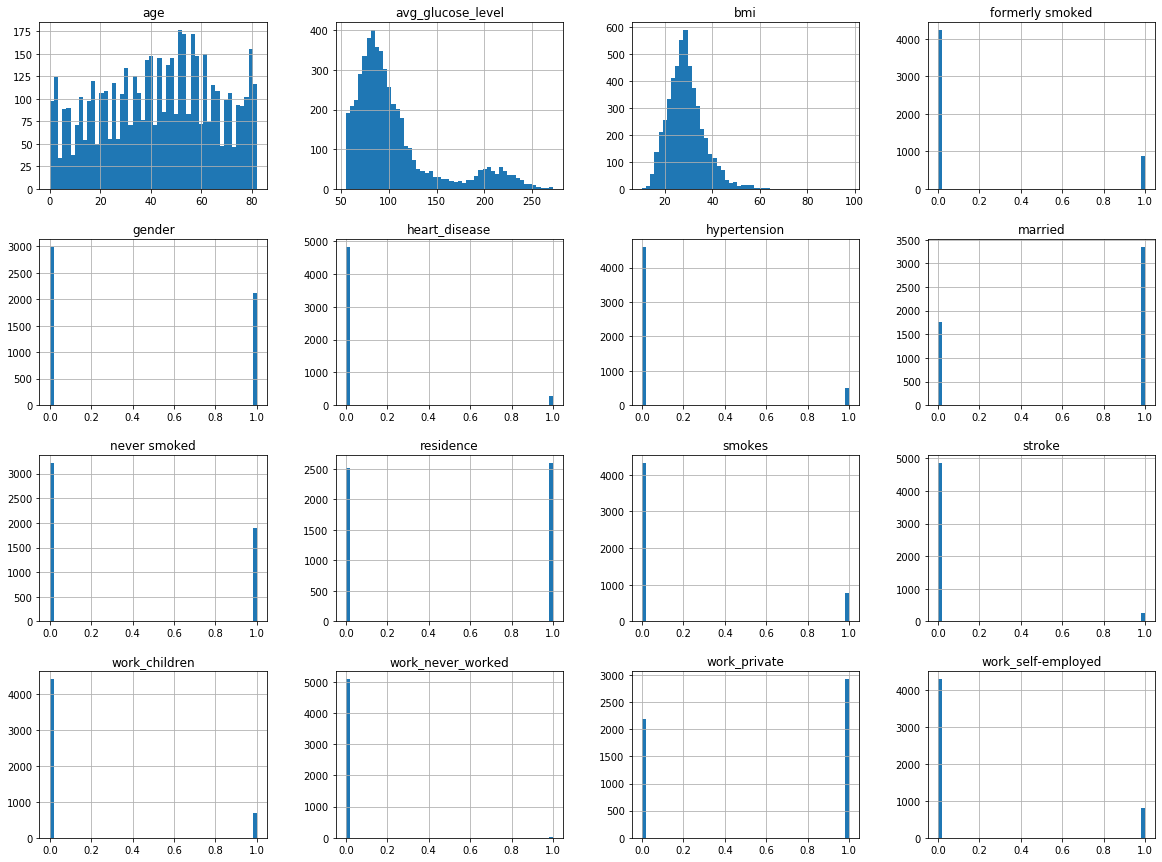

In [23]:
df.hist(bins=50, figsize=(20,15))
plt.show()

In [24]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(highly_correlated)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

t-SNE done! Time elapsed: 7.981482982635498 seconds


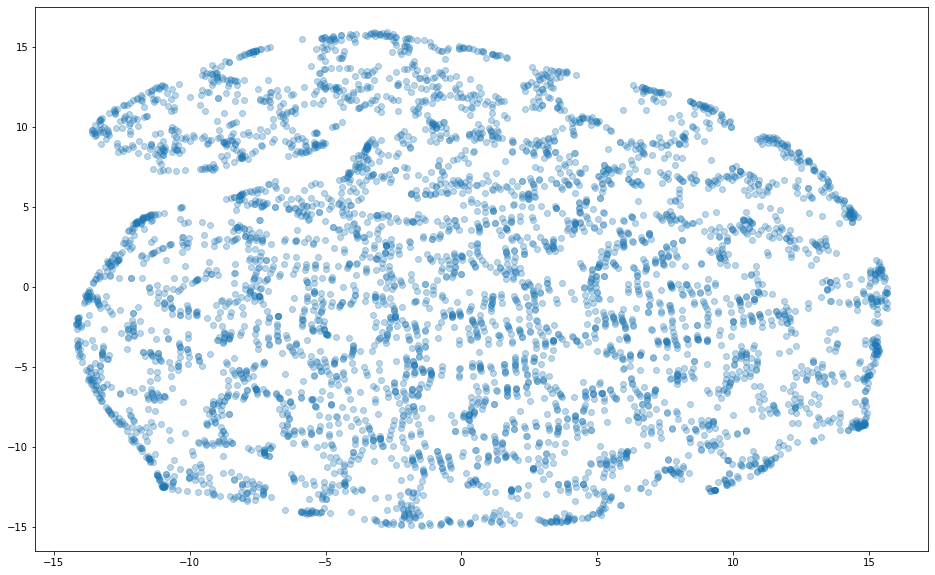

In [25]:
plt.figure(figsize=(16,10))
colours = np.random.rand(21)
sX = df_subset['tsne-2d-one']
sY = df_subset['tsne-2d-two']
plt.scatter(x=sX, y=sY, alpha=0.3)
plt.show()

SMOTE oversampling of imbalanced problem

In [26]:
df.head()

,stroke,age,hypertension,heart_disease,avg_glucose_level,bmi,gender,married,work_never_worked,work_private,work_self-employed,work_children,residence,formerly smoked,never smoked,smokes
0,1,67.0,0,1,228.69,36.6,1,1,0,1,0,0,1,1,0,0
1,1,61.0,0,0,202.21,30.1,0,1,0,0,1,0,0,0,1,0
2,1,80.0,0,1,105.92,32.5,1,1,0,1,0,0,0,0,1,0
3,1,49.0,0,0,171.23,34.4,0,1,0,1,0,0,1,0,0,1
4,1,79.0,1,0,174.12,24.0,0,1,0,0,1,0,0,0,1,0


In [27]:
y = df['stroke']
X = df.drop('stroke', axis=1).values

In [28]:
# random oversampling
ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_resample(X, y)
print(X_ros.shape, len(y_ros))
y_ros

(9720, 15) 9720


0       1
1       1
2       1
3       1
4       1
       ..
9715    1
9716    1
9717    1
9718    1
9719    1
Name: stroke, Length: 9720, dtype: int64

In [29]:
# SMOTE over sampling to reach the same as the majority class in each recurrence time group

# https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html
# https://medium.com/@saeedAR/smote-and-near-miss-in-python-machine-learning-in-imbalanced-datasets-b7976d9a7a79
# https://stackoverflow.com/questions/49395939/smote-initialisation-expects-n-neighbors-n-samples-but-n-samples-n-neighbo
smote = SMOTE(sampling_strategy='not majority', k_neighbors=1, n_jobs=-1)
X_smote, y_smote = smote.fit_resample(X, y)
Counter(y_smote)
X_smote

array([[6.70000000e+01, 0.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.10000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [8.00000000e+01, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [5.90590548e+01, 0.00000000e+00, 2.95273888e-02, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [8.17234300e+01, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.21899971e-02],
       [6.20281813e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

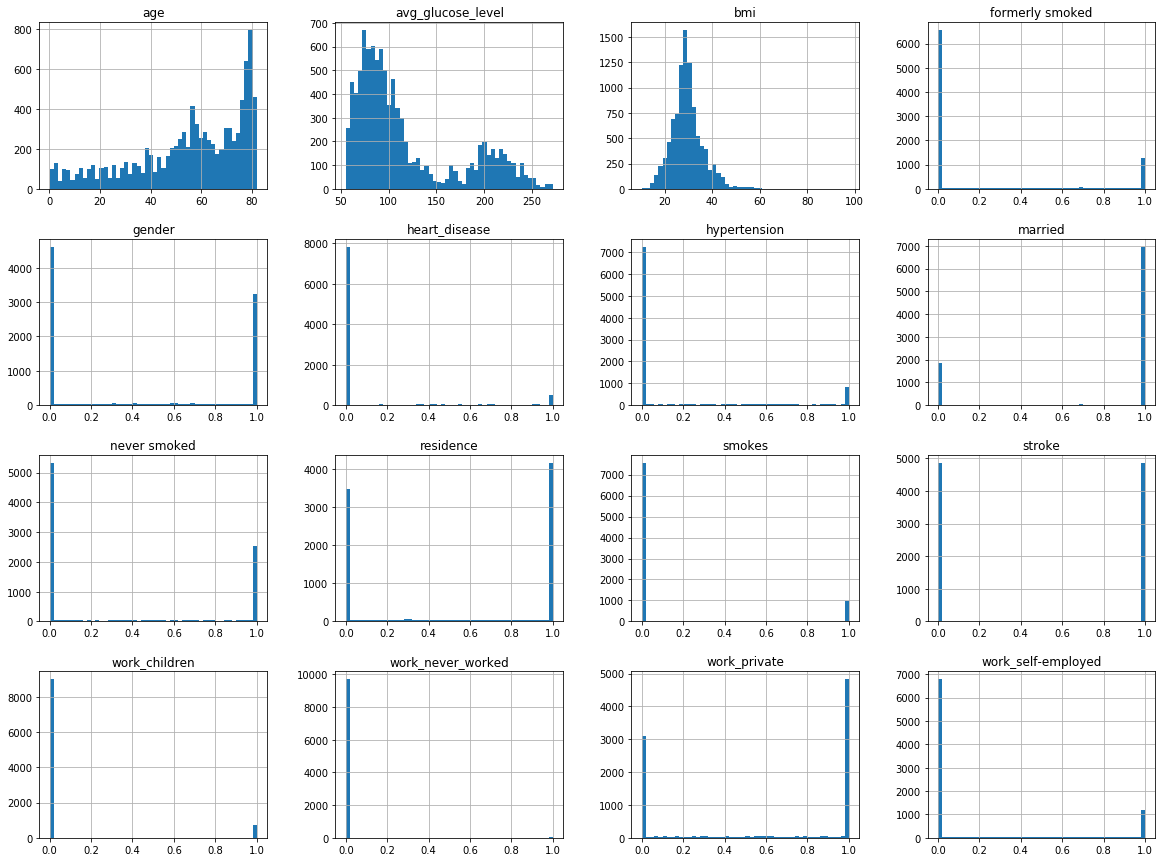

In [30]:
df_smote = pd.DataFrame(X_smote, columns=['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender', 'married',
         'work_never_worked', 'work_private', 'work_self-employed', 'work_children', 'residence',
         'formerly smoked', 'never smoked', 'smokes'])
df_smote['stroke'] = y_smote

df_smote.hist(bins=50, figsize=(20,15))
plt.show()

In [31]:
# how different are the distributions of values on original and oversampled data?

Classification on data

In [32]:
# classification on data
y = df_smote['stroke']
X = df_smote.drop('stroke', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7776, 15) (7776,) (1944, 15) (1944,)


test set accuracy =  0.7870370370370371


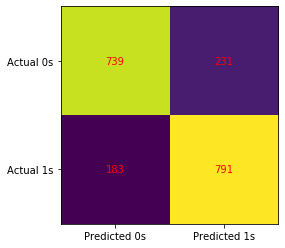

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       970
           1       0.77      0.81      0.79       974

    accuracy                           0.79      1944
   macro avg       0.79      0.79      0.79      1944
weighted avg       0.79      0.79      0.79      1944



In [33]:
# logistic regression
logreg = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('test set accuracy = ', logreg.score(X_test, y_test))

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

print(classification_report(y_test, y_pred))

In [34]:
r = logreg.predict_proba(X_test)
print(r)
print(len(r))

[[0.94444603 0.05555397]
 [0.52329259 0.47670741]
 [0.13363011 0.86636989]
 ...
 [0.93890471 0.06109529]
 [0.95996214 0.04003786]
 [0.32256603 0.67743397]]
1944


In [35]:
print(y_test)

2263    0
491     0
7867    1
7205    1
2431    0
       ..
4955    0
1285    0
2892    0
4423    0
8503    1
Name: stroke, Length: 1944, dtype: int64


In [36]:
print(r[0,1])
#print(y_test[0])

0.055553972292375464


In [37]:
y2 = y_test.reset_index(drop=True)

In [38]:
y2

0       0
1       0
2       1
3       1
4       0
       ..
1939    0
1940    0
1941    0
1942    0
1943    1
Name: stroke, Length: 1944, dtype: int64

In [39]:
def sigmoid(Z):
    return 1 / (1 + np.e**(-Z))

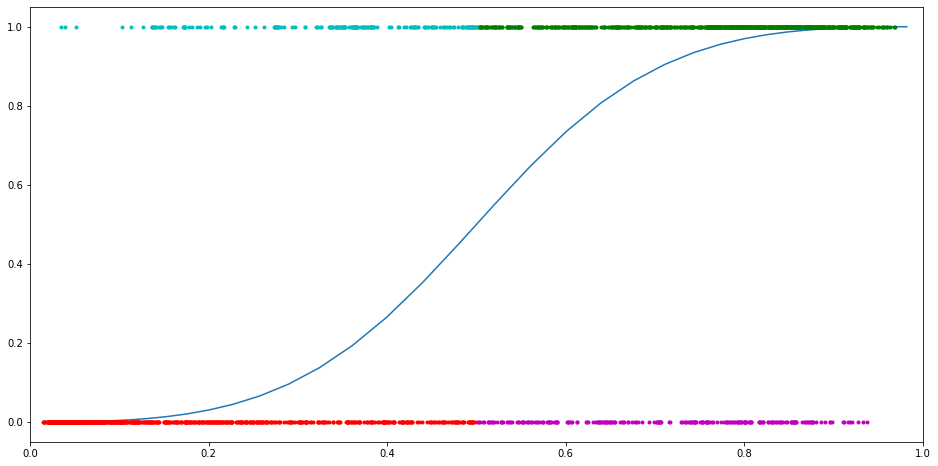

In [40]:
# visualise the logistic regression results
f, axes = plt.subplots(1,1, figsize=(16,8))
plt.plot(sigmoid(np.linspace(-4,4)), sigmoid(np.linspace(-10,10)))
plt.xlim(0,1)


for i in range(len(X_test)):
    
    if y2[i] == 0:
        if r[i,1] < 0.5:
            axes.plot(r[i,1], y2[i], 'r.')
        else:
            axes.plot(r[i,1], y2[i], 'm.')
    else:
        if r[i,1] > 0.5:
            axes.plot(r[i,1], y2[i], 'g.')
        else:
            axes.plot(r[i,1], y2[i], 'c.')



plt.show()

test set accuracy =  0.970164609053498


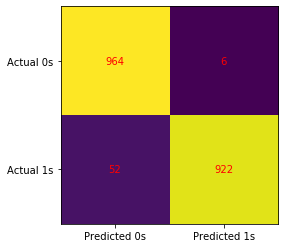

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       970
           1       0.99      0.95      0.97       974

    accuracy                           0.97      1944
   macro avg       0.97      0.97      0.97      1944
weighted avg       0.97      0.97      0.97      1944



In [41]:
# random forest of 25 trees (default is 100)
forest = RandomForestClassifier(n_estimators=25, random_state=0).fit(X_train, y_train)
y_pred = forest.predict(X_test)

print('test set accuracy = ', forest.score(X_test, y_test))

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

print(classification_report(y_test, y_pred))

AttributeError: 'numpy.ndarray' object has no attribute 'clear'

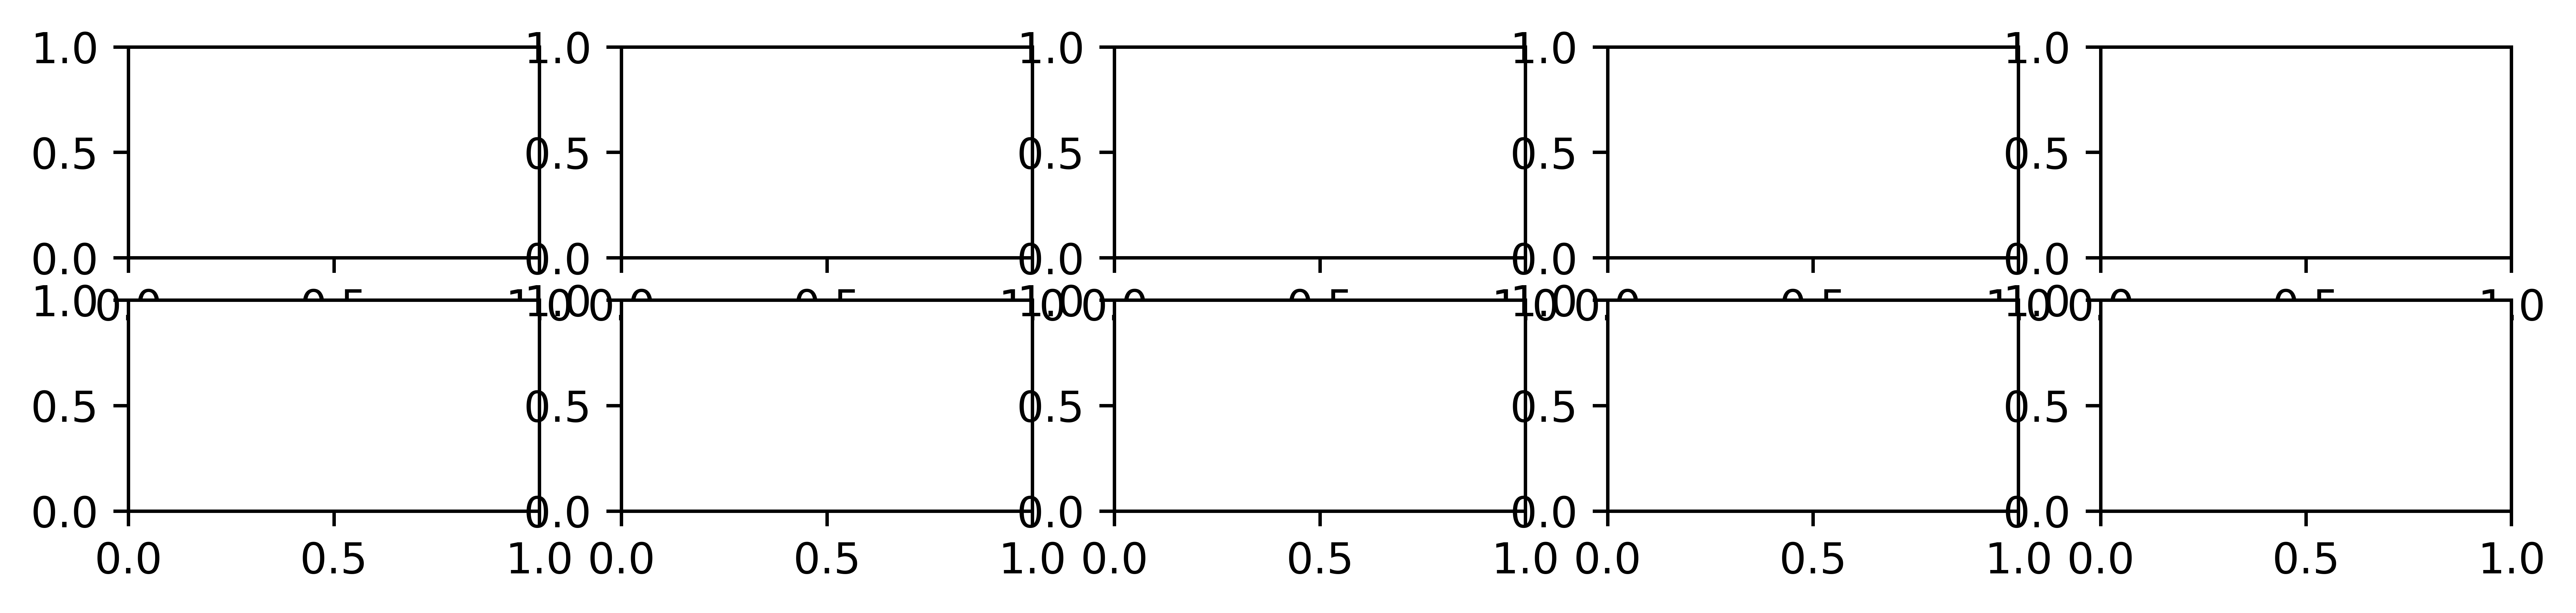

In [42]:
fn = df.columns[1:-1]
cn = df.columns[0]

fig, axes = plt.subplots(nrows = 2,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 10):
    tree.plot_tree(forest.estimators_[index],
                   #feature_names = fn, 
                   #class_names=cn,
                   filled = True,
                   ax = axes[index]);

In [ ]:
feature_names = df_smote.drop('stroke', axis=1).columns

importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.DataFrame(columns = ['Feature', 'Importance', 'err'])

for i in range(len(fn)):
    forest_importances.append({'Feature': fn[i], 'Importance': importances[i], 'err': std[i]})

forest_importances

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot(x=features, y=importances, yerr=std, ax=ax, kind='bar')
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

plt.show()

In [ ]:
# user entry of new "patient" details

new_patient = {
    'age': 50, 
    'hypertension': 1, 
    'heart_disease': 0, 
    'avg_glucose_level': 150.3, 
    'bmi': 30.1, 
    'gender': 1, 
    'married': 0,
    'work_never_worked': 0, 
    'work_private': 1, 
    'work_self-employed': 0, 
    'work_children': 0, 
    'residence': 1,
    'formerly smoked': 1, 
    'never smoked': 0, 
    'smokes': 0
}

print(type(new_patient))

df_new_patient = pd.DataFrame()
df_new_patient = df_new_patient.append(new_patient, ignore_index=True)
df_new_patient

In [ ]:
y_pred = logreg.predict(df_new_patient.values)
y_pred[0]

In [ ]:
y_pred = forest.predict(df_new_patient.values)
y_pred[0]